# Dogs vs Cats with Transfer Learning

In this Notebook we're going to use transfer learning to attempt to crack the [Dogs vs Cats Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats). We will use the lower layers of the VGG-16 pre-trained network.

We are going to downsample the images to 64x64; that's pretty small, but should be enough (I hope). Furthermore, large images means longer training time and I'm too impatient for that. ;)

Lets have plots appear inline:

In [1]:
%matplotlib inline

We're going to need `os`, `numpy`, `matplotlib`, `skimage`, `theano` and `lasagne`. The `pretrained_vgg_models` contains some useful functions for building and acquiring VGG models. We also want to import some layer classes and utilities from Lasagne for convenience.

In [2]:
import os, glob, time, tqdm
import numpy as np
from matplotlib import pyplot as plt
import skimage, skimage.util, skimage.io, skimage.transform
import theano
import lasagne
import pretrained_vgg_models

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer, DropoutLayer, Pool2DLayer, Conv2DLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 25.0% of memory, cuDNN 5105)


## Load the 16-layer VGG-16 model parameters

The `pretrained_vgg_models.VGG16Model.load_params` function loads a `pickle` file containing the VGG-16 network parameters. It will download them from http://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl if necessary.

In [3]:
vgg16_params = pretrained_vgg_models.VGG16Model.load_params()

Define functions for converting an image space between RGB floating point [0,1] range colour space and the VGG colour space that is BGR and has the VGG network mean value centred:

In [4]:
def img_to_vgg(img):
    # (H, W, C) -> (B, C, H, W)
    img = img[None, :, :, :].transpose(0, 3, 1, 2)
    # RGB to BGR
    img = img[:, ::-1, :, :]
    # Scale from [0,1] range to [0,255] and subtract vgg mean
    img = img * 255.0 - vgg16_params['mean value'][None, :, None, None]
    return img.astype(np.float32)

def vgg_to_img(img):
    # Add mean and scale from [0,255] range to [0,1] range
    img = (img + vgg16_params['mean value'][None, :, None, None]) / 255.0
    # BGR to RGB
    img = img[:, ::-1, :, :]
    # (B, C, H, W) -> (H, W, C)
    img = img[0, :, :, :].transpose(1, 2, 0)
    return img.astype(np.float32)

## Load our dataset

Join the Kaggle competition linked above and download the training and test data sets. Unzip them into a directory of your chooseing, and modify the path definitions below to point to the appropriate location:

In [5]:
TRAIN_PATH = r'E:\datasets\dogsvscats\train'
TEST_PATH = r'E:\datasets\dogsvscats\test1'

train_image_paths = glob.glob(os.path.join(TRAIN_PATH, '*.jpg'))
tests_image_paths = glob.glob(os.path.join(TEST_PATH, '*.jpg'))

Now we will define a function that will load an image from the given path, scale it to 64x64 while preserving aspect ratio, and convert it's colour space to VGG:

In [6]:
def load_image(path):
    # Read
    img = skimage.io.imread(path)
    # Convert to float
    img = skimage.util.img_as_float(img)
    # Compute scaled dimensions, while preserving aspect ratio
    # py0, py1, px0, px1 are the padding required to get the image to 64x64
    if img.shape[0] >= img.shape[1]:
        height = 64
        width = int(img.shape[1] * 64.0 / float(img.shape[0]) + 0.5)
        py0 = py1 = 0
        px0 = (64 - width) // 2
        px1 = (64 - width) - px0
    else:
        width = 64
        height = int(img.shape[0] * 64.0 / float(img.shape[1]) + 0.5)
        px0 = px1 = 0
        py0 = (64 - height) // 2
        py1 = (64 - height) - py0
    img = skimage.transform.resize(img, (height, width))
    
    # Convert for use with VGG
    img = img_to_vgg(img)
    
    # Apply padding
    # We do this after converting to VGG colour space, so that the 0-value used for padding will
    # end up being the VGG network mean colour value, rather than black
    img = np.pad(img, [(0, 0), (0, 0), (py0, py1), (px0, px1)], mode='constant')
    
    return img

Show an image to check our code so far:

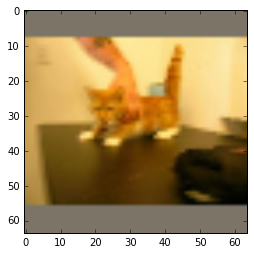

In [7]:
plt.imshow(vgg_to_img(load_image(train_image_paths[0])))
plt.show()

Looks okay.

#### Build the data set:

In [8]:
t1 = time.time()
# Load all image samples
data_X = []
for p in tqdm.tqdm_notebook(train_image_paths):
    data_X.append(load_image(p))

# Concatenate along axis 0 (sample axis)
data_X = np.concatenate(data_X, axis=0).astype(np.float32)
t2 = time.time()

print('Loaded {} images in {:.2f}s'.format(len(train_image_paths), t2 - t1))


Loaded 25000 images in 256.17s


In [9]:
# The ground truth classifications are given by the filename having either a 'dog.' or 'cat.' prefix
# Use:
# 0: cat
# 1: dog
data_y = [(1 if os.path.basename(p).lower().startswith('dog.') else 0) for p in train_image_paths]
data_y = np.array(data_y).astype(np.int32)

print('{} cats, {} dogs'.format((data_y == 0).sum(), (data_y == 1).sum()))

12500 cats, 12500 dogs


#### Split the dataset into train and validation

Note that we implement the split manually here. We could easily use [sklearn.model_selection.StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit). I am refraining for now due to the API changes.

In [10]:
# Create a RNG that we will use throughout the notebook:
rng = np.random.RandomState(12345)

# Get the indices of samples that are dogs and cats
dog_ndx = np.where(data_y == 1)[0]
cat_ndx = np.where(data_y == 0)[0]

# Shuffle them, so that we make a random split
rng.shuffle(dog_ndx)
rng.shuffle(cat_ndx)

# There are 12,500 of each in the data set.
# Build a mask that indicates the samples that are in the validation set
val_mask = np.zeros(data_y.shape, dtype=bool)
# Choose 1250 as validation from each class
val_mask[dog_ndx[:1250]] = True
val_mask[cat_ndx[:1250]] = True

# Now split the data:
val_X = data_X[val_mask]
val_y = data_y[val_mask]

train_X = data_X[~val_mask]
train_y = data_y[~val_mask]

print('Train: X.shape={}, y.shape={}; val: X.shape={}, y.shape={}'.format(train_X.shape, train_y.shape, val_X.shape, val_y.shape))

Train: X.shape=(22500L, 3L, 64L, 64L), y.shape=(22500L,); val: X.shape=(2500L, 3L, 64L, 64L), y.shape=(2500L,)


Delete the original arrays to free up some RAM:

In [11]:
del data_X, data_y

## Build the network

Now we will use the Lasagne API to build the pet classifier network.

We will re-use the convolutional and max-pooling layers of VGG-16, after which we will create our own fully-connected layers.

The first fully-connected layer of the original VGG-16 expects a 7x7x512 input, which requires a 224x224 input image. Given that we only have 64x64 input images, resulting in `pool5` having a 2x2x512 output, the original fully connected layers will not be usable, so we need to make our own layers after this point.

In [12]:
def build_pet_classifier_network():
    net = {}
    # Input layer: shape is of the form (sample, channel, height, width).
    # We are using 3 channel images of size 64 x 64.
    # We leave the sample dimension with no size (`None`) so that the
    # minibatch size is whatever we need it to be when we use it
    net['input'] = InputLayer((None, 3, 64, 64))
    
    # First two convolutional layers: 64 filters, 3x3 convolution, 1 pixel padding
    # flip_filters is on because we are using a network imported from Caffe
    net['conv1_1'] = Conv2DLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = Conv2DLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    # 2x2 max-pooling; will reduce size from 224x224 to 112x112
    net['pool1'] = Pool2DLayer(net['conv1_2'], 2)
    
    # Two convolutional layers, 128 filters
    net['conv2_1'] = Conv2DLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = Conv2DLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    # 2x2 max-pooling; will reduce size from 112x112 to 56x56
    net['pool2'] = Pool2DLayer(net['conv2_2'], 2)
    
    # Three convolutional layers, 256 filters
    net['conv3_1'] = Conv2DLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = Conv2DLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = Conv2DLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    # 2x2 max-pooling; will reduce size from 56x56 to 28x28
    net['pool3'] = Pool2DLayer(net['conv3_3'], 2)
    
    # Three convolutional layers, 512 filters
    net['conv4_1'] = Conv2DLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = Conv2DLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = Conv2DLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    # 2x2 max-pooling; will reduce size from 28x28 to 14x14
    net['pool4'] = Pool2DLayer(net['conv4_3'], 2)
    
    # Three convolutional layers, 512 filters
    net['conv5_1'] = Conv2DLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = Conv2DLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = Conv2DLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    # 2x2 max-pooling; will reduce size from 14x14 to 7x7
    net['pool5'] = Pool2DLayer(net['conv5_3'], 2)
    
    #
    # ALL LAYERS ABOVE ARE PRE-TRAINED
    #
    # ALL LAYERS BELOW ARE NEW
    #
    
    # Dense layer, 1024 units
    net['fc6'] = DenseLayer(net['pool5'], num_units=1024)
    # 50% dropout (only applied during training, turned off during prediction)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    
    # Final dense layer, 2 units: 1 for each class
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=2, nonlinearity=None)
    # Softmax non-linearity that will generate probabilities
    net['prob'] = NonlinearityLayer(net['fc7'], softmax)

    return net

In [13]:
# Build it
pet_net = build_pet_classifier_network()

## Load parameters into the network

Now we must load the parameters that we loaded earlier into our network. The Lasagne helper function `lasagne.layers.set_all_param_values` will do this for us. Given the last layer, it will find all the layers in the network in order and assign them parameters from a list of numpy arrays, such as the `'param values'` list.

Note that we need to discard the paremeters that correspond to the fully-connected layers in the original VGG-16 network. Given that Lasagne will randomly initialise the parameters of newly created layers, the network will already be randomly initialised. As a consequence, we only need to load in parameter values into the pre-trained layers; the new layers will be randomly initialised already so we can leave them alone.

In [14]:
# We only want parameters for the layers up to and including `pool5`, so find out how many we need:
n_params_to_load = len(lasagne.layers.get_all_params(pet_net['pool5']))
# Now load them into the network; note that we take the original params and trim the remaining unused ones
lasagne.layers.set_all_param_values(pet_net['pool5'], vgg16_params['param values'][:n_params_to_load])

## Set up Theano variables, expressions and functions for training the classifier

Create variables for our a batch of input images `x` and a batch of targets `y`:

In [15]:
x_var = theano.tensor.tensor4('x')
y_var = theano.tensor.ivector('y')

Generate expressions for the network output, in both training mode (dropout on) and evaluation mode (dropout off, hence `deterministic=True`):

In [16]:
train_pred_prob = lasagne.layers.get_output(pet_net['prob'], x_var)
eval_pred_prob = lasagne.layers.get_output(pet_net['prob'], x_var, deterministic=True)

Expression for the predicted label in evaluation mode:

In [17]:
eval_pred_y = eval_pred_prob.argmax(axis=1)

Expressions for loss in training and evaluation mode and errors in evaluation mode:

In [18]:
train_losses = lasagne.objectives.categorical_crossentropy(train_pred_prob, y_var)
eval_losses = lasagne.objectives.categorical_crossentropy(eval_pred_prob, y_var)
eval_errs = theano.tensor.neq(eval_pred_y, y_var).astype(theano.config.floatX)

Get the pre-trained and new parameters and compute separate update dictionaries for them, using the ADAM rule:

In [19]:
pretrained_params = lasagne.layers.get_all_params(pet_net['pool5'], trainable=True)
all_params = lasagne.layers.get_all_params(pet_net['prob'], trainable=True)
new_params = [p for p in all_params if p not in pretrained_params]

train_loss = train_losses.mean()
pretrained_updates = lasagne.updates.adam(train_loss, pretrained_params, learning_rate=3e-5)
new_updates = lasagne.updates.adam(train_loss, new_params, learning_rate=3e-4)
train_updates = pretrained_updates.copy()
train_updates.update(new_updates)

Compile Theano functions for training, evaluation and prediction:

In [20]:
print('Compiling train function...')
f_train = theano.function([x_var, y_var], train_losses.sum(), updates=train_updates)

Compiling train function...


In [21]:
print('Compiling evaluation function...')
f_eval = theano.function([x_var, y_var], [eval_losses.sum(), eval_errs.sum()])

Compiling evaluation function...


In [22]:
print('Compiling prediction function...')
f_pred = theano.function([x_var], eval_pred_prob)

Compiling prediction function...


## Train the network

Define functions for extracting mini-batches of data from the training and validation sets:

In [23]:
def train_batch_iter(batch_size):
    # Extract batches from the training set with samples in shuffled order
    # Number of samples
    n = train_y.shape[0]
    
    # Sample indices in shuffled order
    ndx = rng.permutation(n)
    
    n_batches = n // batch_size
    if (n % batch_size) > 0:
        n_batches += 1
    
    # Extract batches
    for i in range(0, n, batch_size):
        batch_ndx = ndx[i:i + batch_size]
        batch_X = train_X[batch_ndx]
        batch_y = train_y[batch_ndx]        
        yield batch_X, batch_y
        
        
def val_batch_iter(batch_size):
    # Extract batches from the validation set with samples in order
    # Number of samples
    n = val_y.shape[0]
    
    n_batches = n // batch_size
    if (n % batch_size) > 0:
        n_batches += 1
    
    # Extract batches
    for i in range(0, n, batch_size):
        batch_X = val_X[i:i + batch_size]
        batch_y = val_y[i:i + batch_size]        
        yield batch_X, batch_y

Define settings for training:

In [24]:
NUM_EPOCHS = 50

The training loop:

In [25]:
print('Training...')

for epoch_i in range(NUM_EPOCHS):
    t1 = time.time()
    
    # TRAIN
    train_loss = 0.0
    # For each batch:
    for batch_X, batch_y in train_batch_iter(128):
        # Accumulate training loss
        train_loss += f_train(batch_X, batch_y)
    # Divide by number of samples to get mean loss
    train_loss /= float(train_y.shape[0])
    
    # VALIDATE
    val_loss = val_err = 0.0
    # For each batch:
    for batch_X, batch_y in val_batch_iter(128):
        # Accumulate loss and error
        l, e = f_eval(batch_X, batch_y)
        val_loss += l
        val_err += e
    # Divide by number of samples to get mean loss and error
    val_loss /= float(val_y.shape[0])
    val_err /= float(val_y.shape[0])
    
    t2 = time.time()
    
    # REPORT
    print('Epoch {} took {:.2f}s: train loss={:.6f}; val loss={:.6f} err={:.2%}'.format(
            epoch_i, t2 - t1, train_loss, val_loss, val_err))

Training...
Epoch 0 took 65.78s: train loss=0.736569; val loss=0.319412 err=13.84%
Epoch 1 took 66.52s: train loss=0.277436; val loss=0.255072 err=11.52%
Epoch 2 took 66.83s: train loss=0.209429; val loss=0.249805 err=10.76%
Epoch 3 took 66.81s: train loss=0.160585; val loss=0.247100 err=9.96%
Epoch 4 took 66.41s: train loss=0.117064; val loss=0.223209 err=8.92%
Epoch 5 took 66.24s: train loss=0.080166; val loss=0.243615 err=9.20%
Epoch 6 took 66.14s: train loss=0.049118; val loss=0.315993 err=8.80%
Epoch 7 took 66.21s: train loss=0.038273; val loss=0.300941 err=8.64%
Epoch 8 took 67.91s: train loss=0.027054; val loss=0.409456 err=9.72%
Epoch 9 took 67.95s: train loss=0.029793; val loss=0.378638 err=8.92%
Epoch 10 took 67.95s: train loss=0.019472; val loss=0.347648 err=8.56%
Epoch 11 took 67.96s: train loss=0.008881; val loss=0.398821 err=8.04%
Epoch 12 took 67.98s: train loss=0.023917; val loss=0.356833 err=8.28%
Epoch 13 took 67.97s: train loss=0.020318; val loss=0.341851 err=8.72%
E

### Apply to some example images from the test set

Sample 4579: predicted as cat, confidence 100.00%


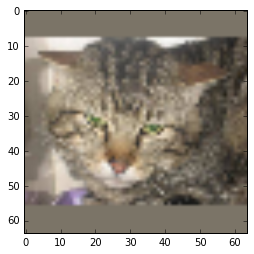

Sample 9171: predicted as dog, confidence 100.00%


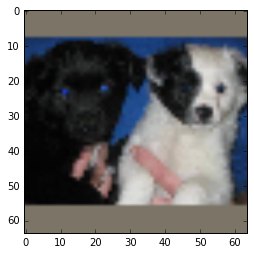

Sample 9320: predicted as dog, confidence 100.00%


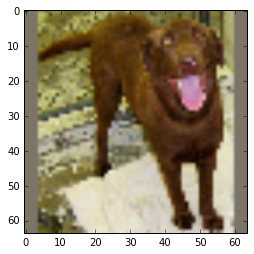

Sample 1209: predicted as cat, confidence 100.00%


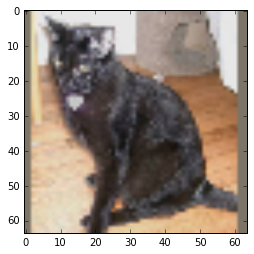

Sample 5354: predicted as dog, confidence 100.00%


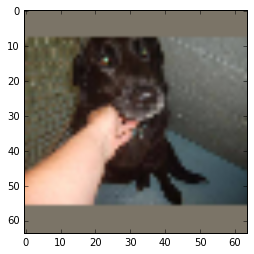

Sample 1297: predicted as dog, confidence 100.00%


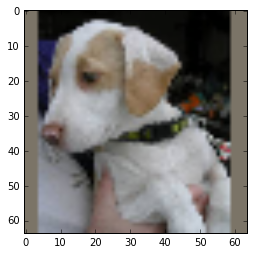

Sample 11702: predicted as dog, confidence 100.00%


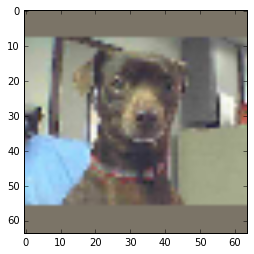

Sample 11708: predicted as dog, confidence 100.00%


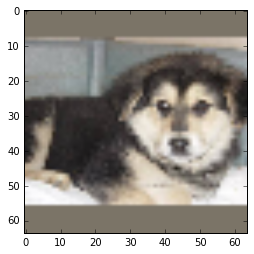

Sample 9699: predicted as cat, confidence 100.00%


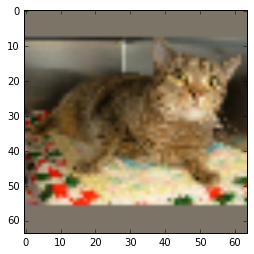

Sample 7749: predicted as cat, confidence 100.00%


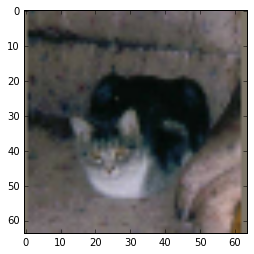

Sample 8779: predicted as cat, confidence 100.00%


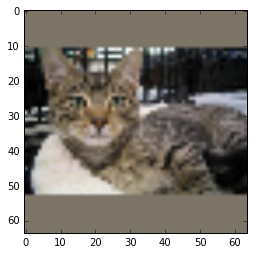

Sample 2796: predicted as cat, confidence 99.38%


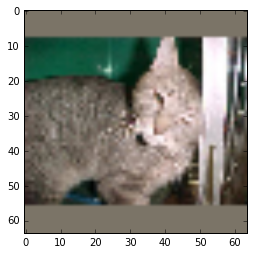

Sample 1797: predicted as cat, confidence 100.00%


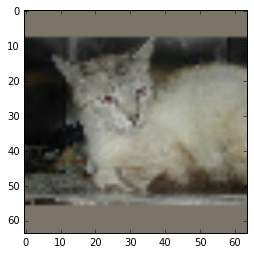

Sample 2979: predicted as dog, confidence 100.00%


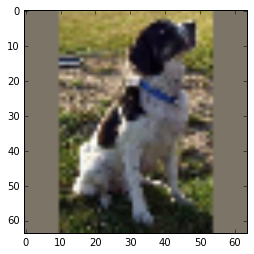

Sample 710: predicted as cat, confidence 100.00%


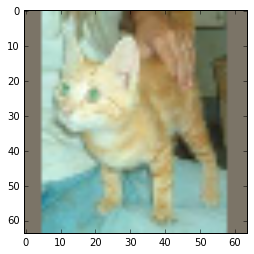

In [26]:
# Number of samples to try
N_TEST = 15

# Shuffle test sample indcies
test_ndx = rng.permutation(len(tests_image_paths))

# Select first `N_TEST` samples
test_ndx = test_ndx[:N_TEST]

for test_i in test_ndx:
    # Load the image
    X = load_image(tests_image_paths[test_i])
    # Predict class probabilities
    pred_prob = f_pred(X)
    # Get predicated class
    pred_y = np.argmax(pred_prob, axis=1)
    
    # Get class name
    pred_cls = 'dog' if pred_y[0] == 1 else 'cat'
    
    # Report
    print('Sample {}: predicted as {}, confidence {:.2%}'.format(test_i, pred_cls, pred_prob[0,pred_y[0]]))
    # Show the image
    plt.figure()
    plt.imshow(vgg_to_img(X))
    plt.show()